## Character-level feed-forward sequence-to-sequence model

In [1]:
import numpy as np
import pandas as pd
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import Sequential, optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [2]:
pairs = pd.read_csv("data/ncbi_02/RAxML/pairs.csv")
sgenes = pd.read_csv("data/ncbi_02/ncbi_sgene_good_unique_aligned_cleaned.csv")

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12744100742839663447
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7025983488
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4961111131365225367
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7739539456
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 483087248850680332
physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Data prep

In [4]:
num_pairs = 100      # Number of samples to train on.
num_pairs = len(pairs)

In [5]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [6]:
for index, pair in pairs.iterrows():
    
    if index == num_pairs:
        break
    
    parent_sgene = sgenes[sgenes["accession"]==pair["parent"]]["sgene_nucleotide"].values[0]
    child_sgene = sgenes[sgenes["accession"]==pair["child"]]["sgene_nucleotide"].values[0]
    
    input_texts.append(parent_sgene)
    target_texts.append(child_sgene)

input_characters = set(chain.from_iterable(input_texts))
target_characters = set(chain.from_iterable(target_texts))

In [7]:
print("input_texts ", len(input_texts))
print("target_texts", len(target_texts))
print("input_characters", len(input_characters), input_characters)
print("target_characters", len(target_characters), target_characters)

input_texts  4368
target_texts 4368
input_characters 4 {'A', 'T', 'G', 'C'}
target_characters 4 {'A', 'T', 'G', 'C'}


In [8]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 4368
Number of unique input tokens: 4
Number of unique output tokens: 4
Max sequence length for inputs: 3822
Max sequence length for outputs: 3822


In [9]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
print("input_token_index", len(input_token_index), input_token_index)
print("target_token_index", len(target_token_index), target_token_index)

input_token_index 4 {'A': 0, 'C': 1, 'G': 2, 'T': 3}
target_token_index 4 {'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [10]:
X = np.zeros(
    (len(input_texts), max_encoder_seq_length), dtype="float32"
)
Y = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)

print("X.shape", X.shape)
print("Y.shape", Y.shape)

X.shape (4368, 3822)
Y.shape (4368, 3822)


In [11]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    for t, char in enumerate(input_text):
        X[i, t] = input_token_index[char] * 1.0
    
    for t, char in enumerate(target_text):
        Y[i, t] = target_token_index[char] * 1.0
        

In [12]:
X_std = (X - np.min(X)) / (np.max(X) - np.min(X))
Y_std = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))

In [13]:
target_texts[0]

'ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACA

## Construct model

In [18]:
batch_size = 32       # Batch size for training.
epochs = 100000         # Number of epochs to train for.

In [19]:
model = Sequential()

model.add(Dense(2, input_dim = X.shape[1], activation = 'sigmoid'))
model.add(Dropout(0.5))

model.add(Dense(Y.shape[1], activation = 'sigmoid', name = 'output'))

adam = optimizers.Adam()
model.compile(optimizer = adam, loss = 'mse', metrics = ['mae'])

In [20]:
#plot_model(model, to_file = 'model.png')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 7646      
_________________________________________________________________
dropout (Dropout)            (None, 2)                 0         
_________________________________________________________________
output (Dense)               (None, 3822)              11466     
Total params: 19,112
Trainable params: 19,112
Non-trainable params: 0
_________________________________________________________________


## Train model

In [21]:
model.compile(
    optimizer = "rmsprop", loss = "mse", metrics = ["mae"]
)

es = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 100, verbose = 1, restore_best_weights = True)

log = model.fit(
    X_std,
    Y_std,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [ es ],
    validation_split = 0.2,
)

Epoch 1/100000
110/110 [==============================] - 6s 4ms/step - loss: 0.1493 - mae: 0.3503 - val_loss: 0.1102 - val_mae: 0.2912
Epoch 2/100000
110/110 [==============================] - 0s 2ms/step - loss: 0.1024 - mae: 0.2750 - val_loss: 0.0731 - val_mae: 0.2259
Epoch 3/100000
110/110 [==============================] - 0s 2ms/step - loss: 0.0711 - mae: 0.2227 - val_loss: 0.0474 - val_mae: 0.1815
Epoch 4/100000
110/110 [==============================] - 0s 2ms/step - loss: 0.0517 - mae: 0.1836 - val_loss: 0.0297 - val_mae: 0.1432
Epoch 5/100000
110/110 [==============================] - 0s 2ms/step - loss: 0.0377 - mae: 0.1489 - val_loss: 0.0181 - val_mae: 0.1106
Epoch 6/100000
110/110 [==============================] - 0s 2ms/step - loss: 0.0280 - mae: 0.1203 - val_loss: 0.0108 - val_mae: 0.0842
Epoch 7/100000
110/110 [==============================] - 0s 2ms/step - loss: 0.0224 - mae: 0.0993 - val_loss: 0.0064 - val_mae: 0.0637
Epoch 8/100000
110/110 [========================

110/110 [==============================] - 0s 2ms/step - loss: 2.6606e-04 - mae: 0.0032 - val_loss: 2.1938e-04 - val_mae: 0.0010
Epoch 59/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.6057e-04 - mae: 0.0030 - val_loss: 2.1967e-04 - val_mae: 9.8750e-04
Epoch 60/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.5549e-04 - mae: 0.0030 - val_loss: 2.1957e-04 - val_mae: 9.8291e-04
Epoch 61/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.5680e-04 - mae: 0.0029 - val_loss: 2.1973e-04 - val_mae: 9.7063e-04
Epoch 62/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.5432e-04 - mae: 0.0029 - val_loss: 2.1964e-04 - val_mae: 9.6517e-04
Epoch 63/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.5683e-04 - mae: 0.0030 - val_loss: 2.1963e-04 - val_mae: 9.5231e-04
Epoch 64/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.5408e-04 - mae: 0.0028 - val_loss: 2.1953e-04

110/110 [==============================] - 0s 2ms/step - loss: 2.3542e-04 - mae: 0.0018 - val_loss: 2.1925e-04 - val_mae: 7.8237e-04
Epoch 114/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3869e-04 - mae: 0.0019 - val_loss: 2.1913e-04 - val_mae: 7.7423e-04
Epoch 115/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3793e-04 - mae: 0.0019 - val_loss: 2.1924e-04 - val_mae: 7.7482e-04
Epoch 116/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3948e-04 - mae: 0.0018 - val_loss: 2.1923e-04 - val_mae: 7.6986e-04
Epoch 117/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.4120e-04 - mae: 0.0018 - val_loss: 2.1908e-04 - val_mae: 7.6898e-04
Epoch 118/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3770e-04 - mae: 0.0018 - val_loss: 2.1912e-04 - val_mae: 7.7029e-04
Epoch 119/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3929e-04 - mae: 0.0018 - val_loss: 

Epoch 168/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3361e-04 - mae: 0.0015 - val_loss: 2.1907e-04 - val_mae: 7.2002e-04
Epoch 169/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3921e-04 - mae: 0.0015 - val_loss: 2.1914e-04 - val_mae: 7.1129e-04
Epoch 170/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3474e-04 - mae: 0.0015 - val_loss: 2.1912e-04 - val_mae: 7.1668e-04
Epoch 171/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3166e-04 - mae: 0.0015 - val_loss: 2.1898e-04 - val_mae: 7.1108e-04
Epoch 172/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.2855e-04 - mae: 0.0015 - val_loss: 2.1920e-04 - val_mae: 7.1579e-04
Epoch 173/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3918e-04 - mae: 0.0016 - val_loss: 2.1939e-04 - val_mae: 7.1436e-04
Epoch 174/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3444e-04 - mae: 0.

110/110 [==============================] - 0s 2ms/step - loss: 2.2915e-04 - mae: 0.0014 - val_loss: 2.1925e-04 - val_mae: 6.8978e-04
Epoch 223/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3282e-04 - mae: 0.0013 - val_loss: 2.1912e-04 - val_mae: 6.9817e-04
Epoch 224/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3151e-04 - mae: 0.0014 - val_loss: 2.1924e-04 - val_mae: 6.9100e-04
Epoch 225/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3257e-04 - mae: 0.0013 - val_loss: 2.1937e-04 - val_mae: 6.9108e-04
Epoch 226/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3447e-04 - mae: 0.0014 - val_loss: 2.1918e-04 - val_mae: 6.8756e-04
Epoch 227/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3210e-04 - mae: 0.0013 - val_loss: 2.1902e-04 - val_mae: 6.8852e-04
Epoch 228/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3245e-04 - mae: 0.0014 - val_loss: 

Epoch 277/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.2996e-04 - mae: 0.0013 - val_loss: 2.1913e-04 - val_mae: 6.6937e-04
Epoch 278/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.2724e-04 - mae: 0.0012 - val_loss: 2.1915e-04 - val_mae: 6.7592e-04
Epoch 279/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3052e-04 - mae: 0.0012 - val_loss: 2.1914e-04 - val_mae: 6.7686e-04
Epoch 280/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3280e-04 - mae: 0.0013 - val_loss: 2.1906e-04 - val_mae: 6.7620e-04
Epoch 281/100000
110/110 [==============================] - 0s 2ms/step - loss: 2.3257e-04 - mae: 0.0013 - val_loss: 2.1912e-04 - val_mae: 6.6562e-04
Restoring model weights from the end of the best epoch.
Epoch 00281: early stopping


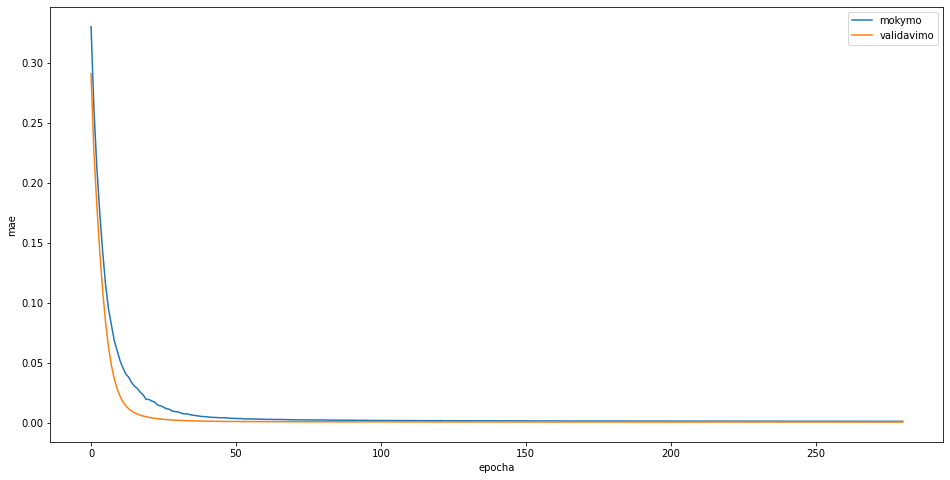

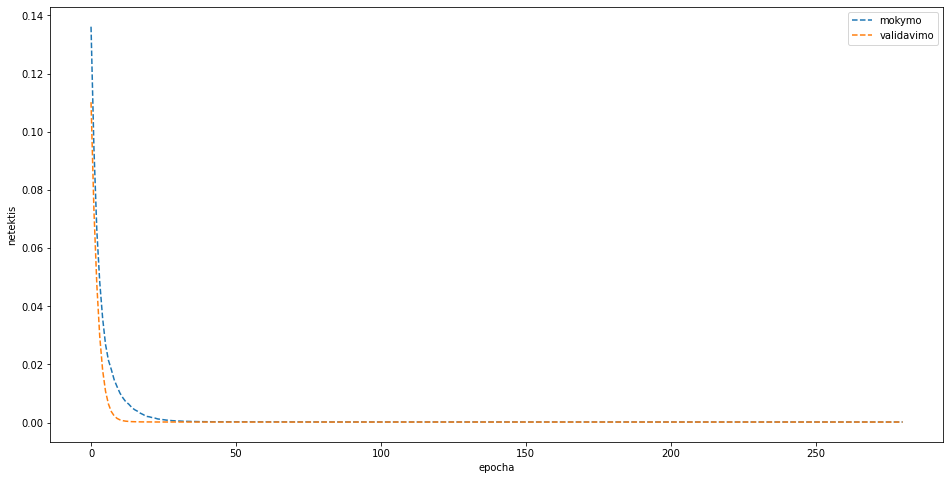

In [22]:
plt.plot(log.history['mae'], label = 'mokymo')
plt.plot(log.history['val_mae'], label = 'validavimo')
plt.ylabel('mae')
plt.xlabel('epocha')
plt.legend()
plt.show()

plt.plot(log.history['loss'], '--', label = 'mokymo')
plt.plot(log.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [150]:
# Save model
model.save("cc_model")

INFO:tensorflow:Assets written to: cc_model/assets


In [151]:
del model

## Inference

In [14]:
model = keras.models.load_model("cc_model")

In [15]:
Y_std_pred = model.predict(X_std)
Y_std_pred.shape

(4368, 3822)

In [16]:
Y_pred = np.round((Y_std_pred + np.min(Y)) * (np.max(Y) - np.min(Y)))
Y_pred.shape

(4368, 3822)

In [17]:
acc = 0.
for i in range(Y.shape[0]):
    acc = acc + accuracy_score(Y[i], Y_pred[i])
acc = acc / Y.shape[0]
acc

0.9993885409897804